# Building Micrograd

[Video](https://www.youtube.com/watch?v=VMj-3S1tku0)<br>
[Repository](https://github.com/karpathy/micrograd)

(Notebook by [mk2112](https://github.com/mk2112))

## Table of Contents

- [Goal](#Goal)
- [What is Micrograd](#What-is-Micrograd)
- [Problem Dissection](#Problem-Dissection)
    - [Understanding Derivatives](#Understanding-Derivatives)
    - [Derivatives in Neural Networks](#Derivatives-in-Neural-Networks)
        - [Value Class - Setup](#Value-Class---Setup)
        - [Value Class - Forward](#Value-Class---Forward)
        - [Value Class - Graph Generation](#Value-Class---Graph-Generation)
    - [Quick Recap](#Quick-Recap)
        - [Value Class - Setting up Backpropagation](#Value-Class---Setting-up-Backpropagation)
- [Neural Networks](#Neural-Networks)
    - [Manual Backpropagation](#Manual-Backpropagation)
    - [Automated Backpropagation](#Automated-Backpropagation)
        - [Value Class - Bug Hunting and Extending](#Value-Class---Bug-Hunting-and-Extending)
    - [Everything comes together](#Everything-comes-together)
- [Doing the exact same thing using PyTorch API](#Doing-the-exact-same-thing-using-PyTorch-API)
- [Back to Neural Networks](#Back-to-Neural-Networks)

In [131]:
import os
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Goal

The goal is to understand what Neural Network (NN) definition, training and backprop look like for the example of [micrograd](https://github.com/karpathy/micrograd). This tutorial is basically a step-by-step project walk-through.<br>
micrograd is an Autograd engine (automatic gradient engine).

> Micrograd has all you need to train NNs condensed to 150 lines of code. Everything else is just efficiency.

Micrograd also implements Backpropagation from scratch.

> Backpropagation allows you to iteratively tune the weights of a NN to minimize a given loss function / improve NN accuracy.

## What is Micrograd?

Micrograd is a tiny, friendly autograd engine that supports automatic differentiation as well as higher-order gradients. It is written in Python and is less than 150 lines of code. It is also a great learning tool for understanding how autograd engines work.

Example usage:

In [132]:
from micrograd.engine import Value
a = Value(-4.0) # create a "Value" object
b = Value(2.0)
c = a + b # transform a and b into c with "+"
c += c + 1
c += 1 + c + (-a)

print(c.data) # prints -1.0

c.backward()

print(a.grad) # prints 3.0
print(b.grad) # prints 4.0

-1.0
3
4


In essence, Micrograd allows you to define values and apply operations to those values. It then automatically keeps track of the value usages, the so called expression graph, to finally compute the gradients resulting from the applied operations.

> The gradient is calculated by - starting from `c` - recursively applying the chain rule to all the nodes in the expression graph.

The example we see above is to show that backpropagation can be applied to various operations. With Multi-Layered Perceptrons (MLP), a subclass of NNs, it's a bit simpler. There we have inputs and weights interacting with each other through matrix multiplication and addition. But that is for later.

## Problem Dissection

### Understanding Derivatives

Let's implement the function $f(x) = 3x^2-4x+5$ in Python:

In [133]:
def f(x):
    return 3*x**2 - 4*x + 5 # arbitrary function

f(3.0)

20.0

Let's go and plot the function:

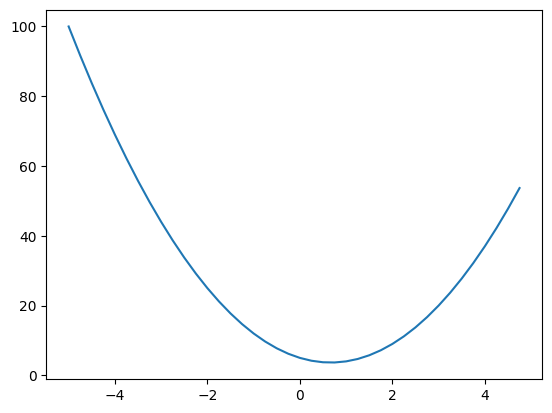

In [134]:
xs = np.arange(-5, 5, 0.25) # set of values from -5 to 5 with step 0.25
ys = f(xs) # applying f to each x
plt.plot(xs, ys) # plot y for each x

Now, what is the derivative at any point $x$ for this function $f(x)$?

To go about this, we should understand what the derivative is telling us about a function $f(x)$. We'll need this understanding when scaling up the functions later.

Officially, this is the definition of being differentiable:<br>
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/aae79a56cdcbc44af1612a50f06169b07f02cbf3)

This asks us to take a positive $h$ close to $0$ to see whether this increases or decreases the value of the function. So we do just that:

In [135]:
h = 0.00000001
x = 3.0

(f(x+h)-f(x))/h # approximate derivative of f at x=3

14.00000009255109

This tells us that at $x=3$ the slope is basically $m=14$.

In [136]:
# Let's get more complex, 3 inputs, 1 output

a = 2.0
b = -3.0
c = 10.0
d = a*b + c

print(d)

4.0


With the above code, `d` is still a function, just like the one in our prior example.<br>
Now what is the derivative of `d` with respect to `a`, `b` and `c`?

In [137]:
h = 0.00001

# This is the point (a, b, c) 
# for which we want the derivative of d
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c # function value at (a, b, c)

a += h       # bump up a by h
d2 = a*b + c # function value at (a+h, b, c)
a -= h       # restore a

b += h       # bump up b by h
d3 = a*b + c # function value at (a, b+h, c)
b -= h       # restore b

c += h       # bump up c by h
d4 = a*b + c # function value at (a, b, c+h)

print('Function value for (a,b,c) d1:', d1)
print()
print('Function value for (a+h,b,c) d2:', d2)
print('slope', (d2 - d1)/h) # show how much the function increased from bumping up a
print('\nFunction value for (a,b+h,c) d3:', d3)
print('slope', (d3 - d1)/h) # show how much the function increased from bumping up b
print('\nFunction value of (a,b,c+h) d4:', d4)
print('slope', (d4 - d1)/h) # show how much the function increased from bumping up c

Function value for (a,b,c) d1: 4.0

Function value for (a+h,b,c) d2: 3.9999699999999994
slope -3.000000000064062

Function value for (a,b+h,c) d3: 4.00002
slope 2.0000000000131024

Function value of (a,b,c+h) d4: 4.00001
slope 0.9999999999621422


These modified functions tell us how the value of the original function changes with respect to the individual input values. This is the partial derivative of the function with respect to either `a`,`b` or `c`.

### Derivatives in Neural Networks

#### Value Class - Setup

We want to move the logic of derivatives over to neural networks. In order to do that, we need fitting data structures. The class `value` takes a single numeric value and keeps track of it. You could do things like<br>`a = Value(3.0)` and<br>`b = Value(-2.0)`,<br>but you should also be able to do `a+b` or `a*b` to construct a graph of operations.

In [138]:
class Value:
    
    def __init__(self, data):
        self.data = data

    # Tells how to print this object nicely  
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition, a+b == a.__add__(b)
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
    
    # Multiplication
    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c # this really is: a.__mul__(b).__add__(c)

print(d) # Value(data=4.0)

Value(data=4.0)


#### Value Class - Forward

What we are missing now is a structure for knowing which operations were applied and which connections between `Value` objects were made. We want to know how specific `Values` produce other `Values`.

We extend `Value` by an attribute `_children`, an empty tuple that internally is stored as a set (this switch from tuple to set is just for performance)

In [139]:
class Value:
    
    # This got extended to take in _children
    def __init__(self, data, _children=()):
        self.data = data
        self._prev = set(_children)
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition, a+b == a.__add__(b)
    def __add__(self, other):
        # We initialize the result's _children to be self and other
        out = Value(self.data + other.data, (self, other))
        return out
    
    # Multiplication
    def __mul__(self, other):
        # We initialize the result's _children to be self and other
        out = Value(self.data * other.data, (self, other))
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c

d # Value(data=4.0)
d._prev # {Value(data=-6.0), Value(data=10.0)}

{Value(data=-6.0), Value(data=10.0)}

We now know the children, but we don't know *how* `d` was created with these values. For that, we extend our `Value` class further. (We'll also add a label attribute for the graph generation down below)<br>
Also added is a label attribute for the graph generation down below. This is purely for visualization purposes.

In [140]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    # Multiplication
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'

f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

print(L)       # Value(data=-8.0)
print(L._prev) # {Value(data=-6.0), Value(data=10.0)}
print(L._op)   # *

Value(data=-8.0)
{Value(data=-2.0), Value(data=4.0)}
*


#### Value Class - Graph Generation

We know now that `d` was produced by the addition of two values `e` and `c`. We can follow which `Value` was created from which and how that was done, like in a Tree making up a solution node.

Now, ideally, we'd like to have a way of visualizing our expression graph. The code for that looks a bit scary:

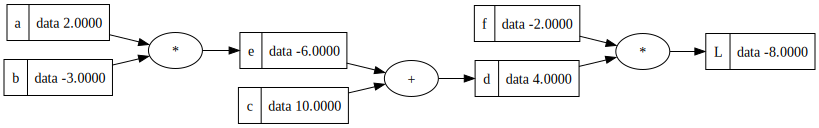

In [141]:
from graphviz import Digraph

# Enumerates all the nodes and edges -> builds a set for them
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

# Draw the graph
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

draw_dot(L)

## Quick Recap

So far,<br>
- we can build mathematical expressions with $+$ and $*$, 
- we can keep track of what `Value` objects are interconnected through what operations, resulting in a new `Value`
- We can visualize the expression graph associated from a resulting `Value`

> The process we currently visualize is the **forward pass**.

What we need to do next is **backpropagation**.

#### Value Class - Setting up Backpropagation

We start with the *forward pass* result (meaning `L`) and, in reverse, calculate the gradient along the intermediate values.<br>
In essence, we calculate per node the derivative of `L` with respect to this node.<br>
The derivative of `L` with respect to `L` is $1$, but what is the derivative of `L` with respect to `f` and so on?<br>
In other words, we want to know to what extent the weights/nodes affect the prediction/`L` through this mathematical structure.

To solve this, we need to know per node the derivative of `L` with respect to that node's value.

For every `Value`, by default the derivative is `0`, meaning no effect on the prediction takes place. This will be modified accordingly for each `Value`. 

> The gradient is the derivative of the loss function with respect to the current `Value`.

In [142]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition, a+b == a.__add__(b)
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    # Multiplication
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        return Value(t, (self, ), 'tanh')

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'

f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

print(L)       # Value(data=-8.0)
print(L._prev) # {Value(data=-6.0), Value(data=10.0)}
print(L._op)   # +

Value(data=-8.0)
{Value(data=4.0), Value(data=-2.0)}
*


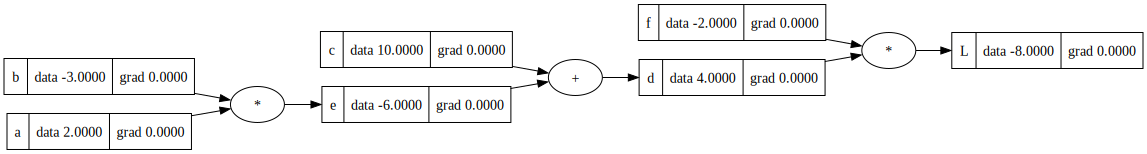

In [143]:
from graphviz import Digraph

# Enumerates all the nodes and edges -> builds a set for them
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

# Draw the graph
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

draw_dot(L)

With this structure, we now have a slot per node to store the backpropagated value. But that storing part is still missing, and so is the calculation part.<br>Let's play with this first.

In [144]:
# This is just always the case
L.grad = 1.0

# As L = d * f is given
# we're certain that dL/dd = f
d.grad = f.data
# and therefore this is also true
f.grad = d.data

Ok, easy. But now, let's get to the crux of backpropagation. If you get this, you get the training of NNs. Basically.<br>Let's say we now need to derive $\frac{dL}{dc}$:

**Known:**<br>
$\frac{dL}{dd} = -2.0$<br><br>
We can also say that the *local derivative* of both $c$ and $e$ is $1$, respectively. This is because $d = c + e$.<br>
$\frac{dd}{dc} = 1.0$<br>
$\frac{dd}{de} = 1.0$

**Wanted:**<br>
$\frac{dL}{dc} = \frac{dL}{dd} * \frac{dd}{dc} \rightarrow$ **That's the chain rule!**

The chain rule is this:<br>
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/e1a610aa8446be002e2e30d7121f6a87273d4caa)

> As the plus node's *local derivatives* are $1$, the plus sign basically routes the sum's gradient equally down to the values that were summed. A plus operation node will simply distribute the gradient we already calculated back to the child nodes evenly.

Going back further, reaching `a` and `b`, we re-apply the chain rule. Combined with the grads for `c` and `e`, this is the result:

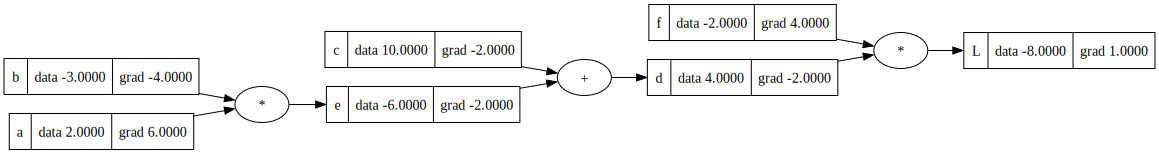

In [145]:
# Gradients of sum
c.grad = d.grad * (1) # dL/dc = dL/dd * dd/dc = dL/dd * 1
e.grad = d.grad * (1) # dL/de = dL/dd * dd/de = dL/dd * 1

# Gradients of multiplication
a.grad = e.grad * b.data # dL/da = dL/de * de/da = dL/de * b
b.grad = e.grad * a.data # dL/db = dL/de * de/db = dL/de * a

draw_dot(L)

Now, let's look at the effects that twisting/changing the variables has on `L`:

In [146]:
# Moving leaf nodes in gradient direction
# This is manual backpropagation in essence
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# Forward pass
e = a * b
d = e + c
L = d * f

print(L.data) # L increased

-7.286496


## Neural Networks

Let's take the concepts of forward pass and backpropagation and apply them to the concept of NNs.

We want to eventually build out neural networks (NNs):
![](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)

There exists a mathematical model for what a neuron in such an NN looks like:
![](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

The activation function used here (as done in CS231n) is `tanh`:

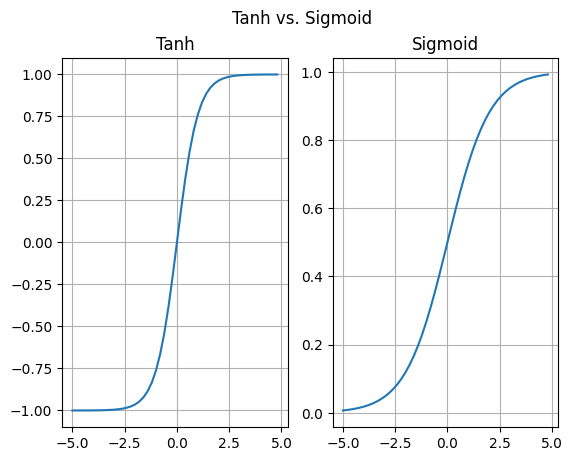

In [147]:
# Just for reference: This is the sigmoid function, also commonly used for this task, not related to tanh
def sigmoid(x):
    a = []
    for i in x:
        a.append(1/(1+math.exp(-i)))
    return a

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Tanh vs. Sigmoid')

lower = -5
upper = 5
step = 0.2

ax1.grid()
ax1.set_title('Tanh')
ax1.plot(np.arange(lower, upper, step), np.tanh(np.arange(-5, 5, 0.2))) # Tanh activation function
ax2.grid()
ax2.set_title('Sigmoid')
ax2.plot(np.arange(lower, upper, step), sigmoid(np.arange(-5, 5, 0.2))) # Sigmoid activation function (alternative)

plt.show()

The `tanh` function's range is [-1,1], while the `sigmoid` function's is [0,1]. Per iteration, `tanh` will produce rather more precise gradients, leading to more efficient training cycles.

In [148]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias b
b = Value(6.8813735870195432, label='b') # Making sure backprop numbers come out nice later on

# Neuron value n: x1w1+x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# Squashed activation o: tanh(n)
o = n.tanh(); o.label='o'

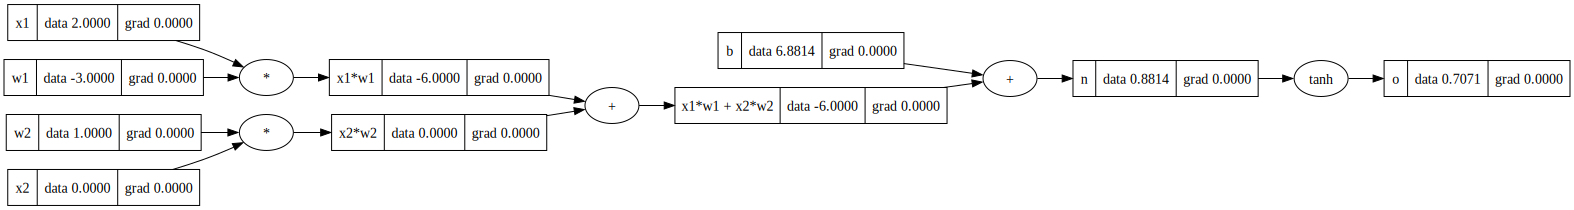

In [149]:
draw_dot(o)

### Manual Backpropagation

Now we're going to perform manual backpropagation (again). This means, starting from `o` we want to fill in aĺl the gradients.

> By the end, we can ideally answer "What is the derivative of `o` with respect to `x1, w1, x2, w2`?" These are what we can directly change and what we care about the most.

We now need to know the derivative of `tanh`.

In [150]:
# Always a given
o.grad = 1.0

# o = tanh(n), what is do/dn?
# do/dn = 1 - tanh(n)**2
n.grad = 1 - o.data**2

# As addition "just" splits the gradient
x1w1x2w2.grad = n.grad
b.grad = n.grad

# And addition again
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

# And multiplication handles like in the example above
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data # this will be 0: changing this value does nothing, as its multiplied by 0

### Automated Backpropagation

Doing backprop manually is amateur-hour. It should be automated. Below, we now re-write/extend the `Value` class.

To be more precise, we extend the `Value` object by a `_backward` attribute, a lambda expression initialized with `None`. Per operation, `_backward` is populated with a concrete gradient calculation step.<br><br>
This code below is really beautiful:


In [151]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # Does nothing by default
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition, a+b == a.__add__(b)
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            # Route gradient to parents
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward
        return out
     
    # Multiplication
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            # Route gradient affected by data of other node
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data
        
        out._backward = _backward
        return out
    
    # Tanh activation function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            # Local derivative times gradient of child node
            self.grad = (1 - t**2) * out.grad
        
        out._backward = _backward
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'

f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

print(L)       # Value(data=-8.0)
print(L._prev) # {Value(data=-6.0), Value(data=10.0)}
print(L._op)   # *

Value(data=-8.0)
{Value(data=-2.0), Value(data=4.0)}
*


In [152]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias b
b = Value(6.8813735870195432, label='b') # Making sure backprop numbers come out nice later on

# Neuron value n: x1w1+x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# Squashed activation o: tanh(n)
o = n.tanh(); o.label='o'

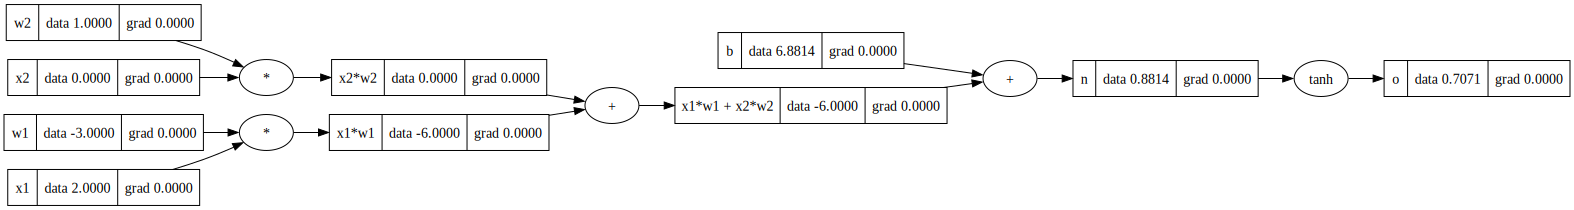

In [153]:
draw_dot(o)

Now we don't have to do Backprop manually anymore:

In [154]:
o.grad = 1.0 # Base case for backprop multiplication to work
o._backward()
n._backward()
b._backward() # Nothing happens, as this is a leaf
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

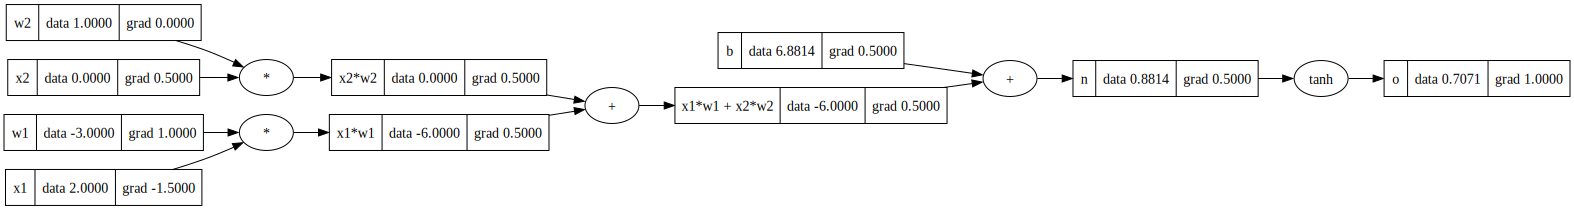

In [155]:
draw_dot(o)

We now have one last thing to get rid of: Having to call `_backward()` manually in a particular order (one after another, backwards) on our nodes.

Going backwards through our expression graph means for every node, that everything following it is already calculated. This requires ordering. This ordering of graphs can be done using **topological sort**. This places the nodes so that edges always go in one common direction:<br><br>
![](https://assets.leetcode.com/users/images/63bd7ad6-403c-42f1-b8bb-2ea41e42af9a_1613794080.8115625.png)

The ordering from topological sort guarantees that gradients are computed and propagated in a manner that avoids redundant computations and maximizes computational parallelism, resulting in improved efficiency and accelerated convergence rates. Topological sort acts as an organizing principle, facilitating a seamless flow of gradients through the network.<br>[Read More...](https://www.geeksforgeeks.org/topological-sorting/)

In [156]:
# Topological sort
# Building the graph topologically

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v) # Only add node if all preceeding nodes were processed first
build_topo(o)

for t in topo:
    print(t)

Value(data=6.881373587019543)
Value(data=-3.0)
Value(data=2.0)
Value(data=-6.0)
Value(data=1.0)
Value(data=0.0)
Value(data=0.0)
Value(data=-6.0)
Value(data=0.8813735870195432)
Value(data=0.7071067811865476)


This now is the exact order by which we need to apply `_backward()` to our graph, starting from `o`.

In [157]:
o.grad = 1.0

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v) # Only add node if all nodes were processed first
build_topo(o)

for node in reversed(topo):
    node._backward()

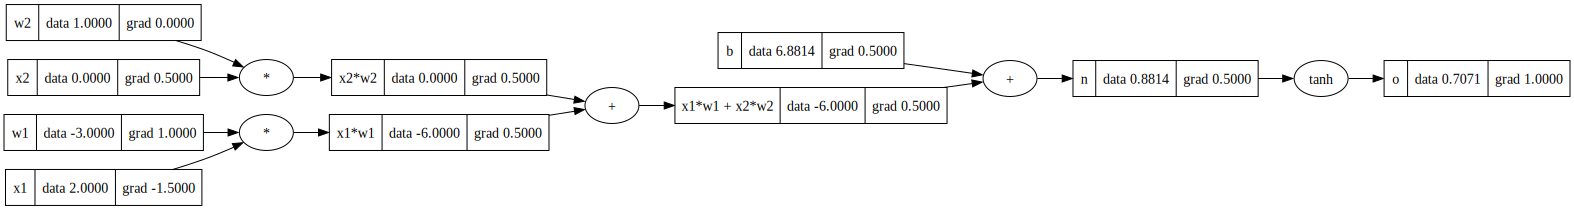

In [158]:
draw_dot(o)

We now go on and plant this logic into the Value class. This is the new class structure:

In [159]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # Does nothing by default
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    # Multiplication
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data
        
        out._backward = _backward
        return out
    
    
    # Tanh activation function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) # Only add node if all nodes were processed first
        build_topo(self)
        
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()

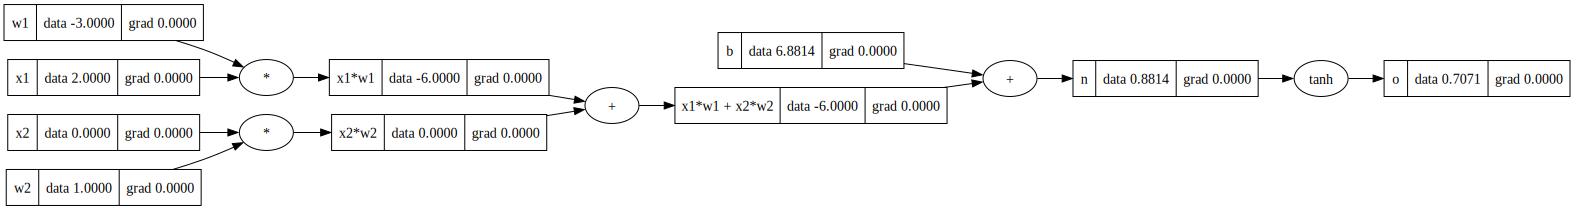

In [160]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias b
b = Value(6.8813735870195432, label='b') # Making sure backprop numbers come out nice later on

# Neuron value n: x1w1+x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# Squashed activation o: tanh(n)
o = n.tanh(); o.label='o'

draw_dot(o)

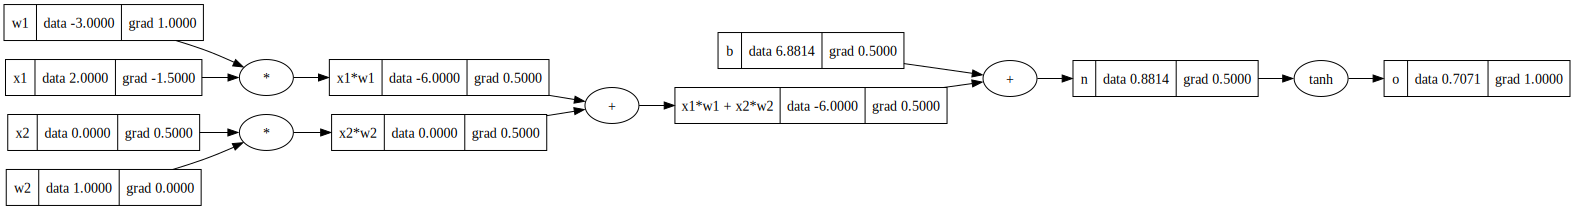

In [161]:
o.backward()
draw_dot(o)

#### Value Class - Bug Hunting and Extending

We built backpropagation. At least for one neuron `o`.<br>**But we have a bug.** See this:

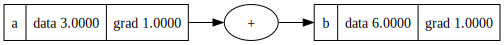

In [162]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

The gradient should be $2$, because `a+a` is just equal to `2*a`. The faulty behavior persists in this example too:

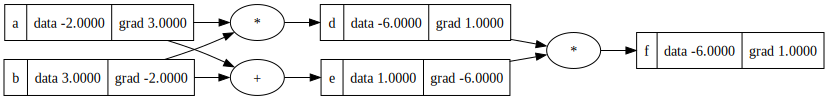

In [163]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label='d'
e = a + b; e.label='e'
f = d * e; f.label='f'

f.backward()
draw_dot(f)

We seem to have a problem as soon as a variable is used more than once. But that is the case most of the time in real-world examples.<br><br>**We actually need to acumulate the gradients rather than setting/overriding them**.<br><br> 
Also, let's extend the `Value` class further. E.g. we can't do `a = Value(2.0) + 1.0` or `a = Value(2.0) * 2.0`. Also, let's access division and the detail operations behind `tanh` now.

A fixed and extended version of the `Value` class looks like this (see the backwards-functions for `+=` bugfix):

In [164]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # Does nothing by default
        self._prev = set(_children)
        self._op = _op
        self.label = label
            
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Addition
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # Extension
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad  # Bugfix
            other.grad += 1.0 * out.grad # Bugfix
        
        out._backward = _backward
        return out
    
    # Negation (special multiplication)
    def __neg__(self): # -self
        return -1 * self
    
    # Subtraction (special addition)
    def __sub__(self, other): # self - other
        return self + (-other)
 
    # Multiplication
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # Extension
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += out.grad * other.data # Bugfix
            other.grad += out.grad * self.data # Bugfix
        
        out._backward = _backward
        return out
    
    # Power (special multiplication)
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting in/float powers (for now)"
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out
    
    # Called if self is on right side of *
    def __rmul__(self, other): # other * self
        return self * other
    
    # Called if self is on right side of +
    def __radd__(self, other): # other + self
        return self + other
    
    # True division (special multiplication)
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    # Tanh activation function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad # Bugfix
        
        out._backward = _backward
        return out
    
    # Exponential function
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out
    
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) # Only add node if all nodes were processed first
        build_topo(self)
        
        self.grad = 1.0 # Seed gradient always 1.0
        
        for node in reversed(topo):
            node._backward()

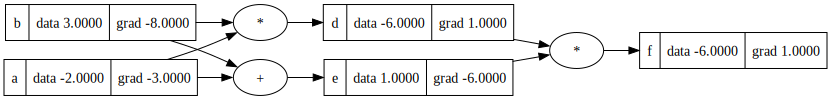

In [165]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label='d'
e = a + b; e.label='e'
f = d * e; f.label='f'

f.backward()
draw_dot(f)

In [166]:
# Just a sanity check 
# for the newly implemented arithmetics

a = Value(2.0)
b = Value(4.0)

print(a + 2)
print(2 + a)
print(a * 2)
print(2 * a)
print(-a)
print(a - b)

print(a.exp())
print(a / b) # Division: a/b = a * (1/b) = a * (b**(-1)), so we use a function realizing x**k

Value(data=4.0)
Value(data=4.0)
Value(data=4.0)
Value(data=4.0)
Value(data=-2.0)
Value(data=-2.0)
Value(data=7.38905609893065)
Value(data=0.5)


### Everything comes together

We will now change the example from above, and more precisely, we will change how we define `o` using the now available, more detailed operations making up `tanh`.

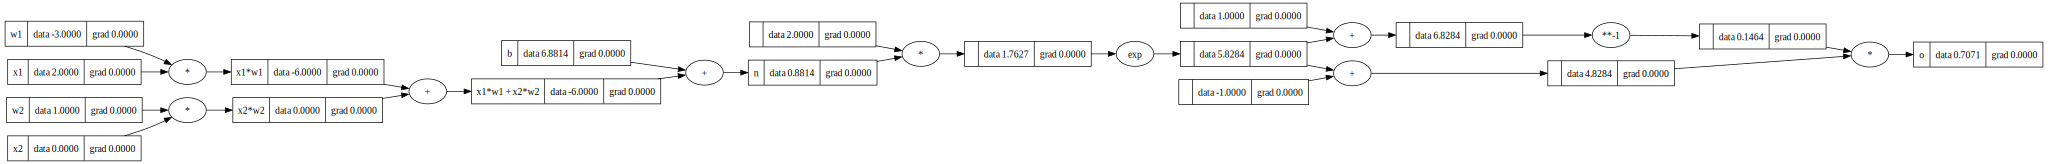

In [167]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias b
b = Value(6.8813735870195432, label='b') # Making sure backprop numbers come out nice later on

# Neuron value n: x1w1+x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# Squashed activation o: tanh(n) EXPLICITLY IMPLEMENTED
e = (2*n).exp()
o = (e - 1)/(e + 1); o.label='o'

draw_dot(o)

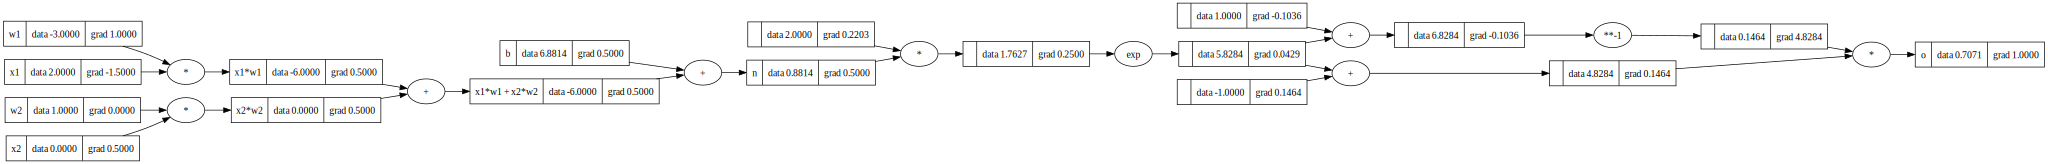

In [168]:
# The x1, x2 ... gradients should remain the same
o.backward()
draw_dot(o)

**Why did we do what we just did**?<br>
Essentially, we changed the level of implementation. It is up to us if we want to just implement one `tanh` or if we go on and implement that function's atomic steps explicitly. This in essence was training on how to deal with operations, with zooming in and out of an implementation approach and with new gradient calculations necessary for the new steps.

---

## Doing the exact same thing using PyTorch API

The original micrograd is modeled roughly after the PyTorch syntax. In fact, it can just as well be implemented entriely in PyTorch. It gets a bit messy though, as this requires values to be stored in PyTorch's Tensor objects.

In [169]:
x1 = torch.Tensor([2.0]).double();  x1.requires_grad = True  # single element tensors
x2 = torch.Tensor([0.0]).double();  x2.requires_grad = True  # tensor datatype is now double
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True # default dtype was float32
w2 = torch.Tensor([1.0]).double();  w2.requires_grad = True  # now its float64 aka double
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b # perform arithmetic just like with micrograd
o = torch.tanh(n)

print(o.data.item())
o.backward() # backward() is pytorch's autograd function

print('---') # These values below are just like micrograds left most layer
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [170]:
o.item()

0.7071066904050358

The big deal with PyTorch is that now everything is significantly more efficient, as using Tensor objects allows for more functionality/versatility.

## Back to Neural Networks

Now that we have some vehicles to build complex mathematic expressions, we can build NNs. We'll do that piece by piece and end up with a 2-layer multi-layer perceptron (MLP).<br>
In theory, micrograd's output is a neuron activation, therefore we built a neuron taking in and processing input. But we will now do that utilizing the powers of PyTorch.

For the sake of completeness, here is the schematic for an NN again:
![](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)

In [171]:
# One neuron is able to take multiple inputs and produce one activation scalar
class Neuron:
    def __init__(self, nin):
        # nin -> number of inputs to this neuron
        # Random weight [-1, 1] per input
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        # Bias controls general "trigger happiness" of neuron
        self.b = Value(np.random.uniform(-1,1))
        
    def __call__(self, x): # running neuron(x) -> __call__ triggered
        # w * x + b
        # zip() creates iterator running over the tupels of two iterators
        # self.b is taken as the sum's start value and then added upon
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        # Squash the activation with tanh
        out = act.tanh()
        return out
    
    # Convenience code to gather the neuron's parameter list
    def parameters(self):
        return self.w + [self.b]


# A set of neurons making up a (hidden/input/output) NN layer
# E.g. n = Layer(2, 3) -> 3 2-dimensional neurons
class Layer:
    # nout -> how many neurons/outputs should be in this layer
    # nin -> how many inputs are to be expected per neuron
    def __init__(self, nin, nout):
        # literally create a list of neurons as needed
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x): # running layer(x) -> __call__ triggered
        # return all of the layer's neuron activations
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    # Convenience code to gather all parameters of layer's neurons
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


# MLP -> Multi-layer perceptron -> NN
class MLP:
    # nin -> number of inputs to the NN
    # nouts -> list of numbers, defines sizes of all wanted layers
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x): # mlp(x) -> call all layer(x)s values in NN
        for layer in self.layers:
            # Neat forward pass implementation
            x = layer(x)
        return x
    
    # Convenience code to gather all parameters of all layer's neurons
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [172]:
x = [2.0, 3.0, -1.0]  # input values
n = MLP(3, [4, 4, 1]) # 3 inputs into 2 layers of 4 and one output layer
n(x)

Value(data=-0.35485201679609474)

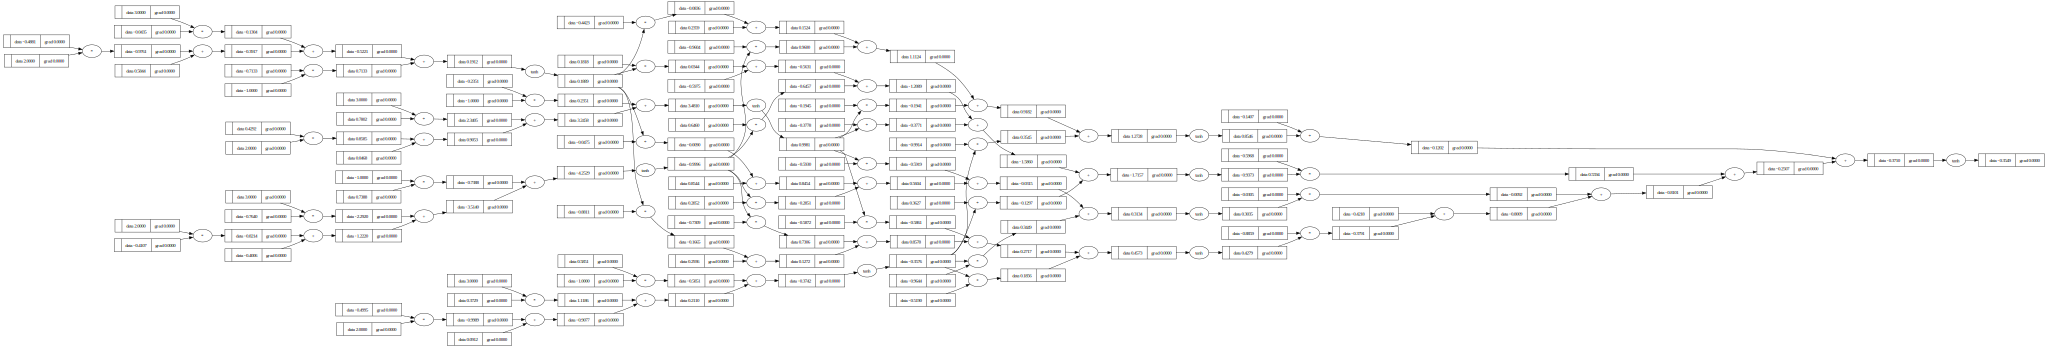

In [173]:
draw_dot(n(x))

With micrograd, we are now able to relatively easily backpropagate through this mess. Let's do that, let's define an example training set with features and labels.

In [174]:
# Features/Inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# Desired targets
ys = [1.0, -1.0, -1.0, 1.0]

# Get the NN's current prediction for xs
ypred = [n(x) for x in xs]

for i in range(len(ypred)):
    print(f'{ypred[i]}\t-> {ys[i]}')

Value(data=-0.35485201679609474)	-> 1.0
Value(data=-0.6935645915522289)	-> -1.0
Value(data=-0.2338056011806672)	-> -1.0
Value(data=-0.1733087507014572)	-> 1.0


The NN doesn't perform very well at this point. We need to measure how good/bad the NN performs to make steps towards bettering its performance. **We need a loss function.**

In [175]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
print('loss:', loss.data)

loss: 3.893233928221731


This loss now has to be as low as possbile. If loss is low, the predictions match the expectations by the labels.

In [176]:
loss.backward()

In [177]:
# Example neuron weight with now calculated gradient
print(n.layers[0].neurons[0].w[0].grad)
print(n.layers[0].neurons[0].w[0].data)

-3.4612740639695887
-0.48807403391852855


In [178]:
# Weight Update with Backpropagation's gradients
for p in n.parameters(): 
    p.data += -0.01 * p.grad

In [179]:
# Show updated weight
print(n.layers[0].neurons[0].w[0].data)

-0.45346129327883267


In [180]:
# Run epochs and show respective predictions
for t in range(5):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    print(f'{loss.data}\t - {[y.data for y in ypred]}')

    loss.backward()
    for p in n.parameters(): 
        p.data += -0.01 * p.grad

2.657760907904723	 - [0.030016018807582034, -0.62499821032622, -0.13209540933974598, 0.0928025223871327]
1.7690227036554773	 - [0.5635968395865243, -0.4970038542632058, 0.02811676935059439, 0.48178597935733736]
1.7541599831804269	 - [0.7323576102757496, -0.3773962687447819, 0.09609186196993974, 0.6942635802632112]
1.5854650800140717	 - [0.7635476698122728, -0.3232495068148732, 0.010083524124373005, 0.7735150781419643]
1.0903330754634175	 - [0.753268599589622, -0.36005783017961557, -0.2407093879866155, 0.7916529882410845]
